## The problem

- Walking around in a 2D maze, with walls put in random locations

Things to try next:

- Figure out the Q values, see if there's an error there
- Directly penalize walking into walls

In [1]:
import gym
from gym.spaces import Discrete
import numpy as np
import ray
from ray.rllib.agents.dqn import DQNTrainer
from ray.rllib.agents.ppo import PPOTrainer
from ray.rllib.models.preprocessors import get_preprocessor 
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import copy

In [31]:
import torch

In [2]:
action_names = {
    0 : "up",
    1 : "down",
    2 : "right",
    3 : "left"
}

In [3]:
ray.init(ignore_reinit_error=True)

{'node_ip_address': '127.0.0.1',
 'raylet_ip_address': '127.0.0.1',
 'redis_address': '127.0.0.1:52767',
 'object_store_address': '/tmp/ray/session_2022-03-31_09-31-15_744520_15929/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-03-31_09-31-15_744520_15929/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-03-31_09-31-15_744520_15929',
 'metrics_export_port': 63396,
 'gcs_address': '127.0.0.1:61676',
 'node_id': '81a3a7394557382892438fd692c6a767df273a3d74eba258e0ed4d2b'}

In [4]:
class RandomMazeEnvironment(gym.Env): 
    def __init__(self, env_config):
        self.ylen = env_config.get("ylen", 5)
        self.xlen = env_config.get("xlen", 5)
        
        self.action_space = gym.spaces.Discrete(4)
        
        # show entire state, not just nearby the player
        # self.observation_space = gym.spaces.Dict({
        #     "player" : gym.spaces.Discrete(self.ylen*self.xlen),
        #     "walls" : gym.spaces.MultiBinary(self.ylen*self.xlen)
        # })
        # self.observation_space = gym.spaces.MultiBinary([2, self.ylen, self.xlen])

        # see https://docs.ray.io/en/latest/rllib/rllib-models.html
        # looks like they mainly just preprocess discrete/multidiscrete and atari?
        # what about box?? hmm. i guess those go without preproc?
        
        # self.observation_space = gym.spaces.MultiDiscrete([2,2,2,2])
        # self.observation_space = gym.spaces.Tuple([Discrete(2), Discrete(2), Discrete(2), Discrete(2)])
        self.observation_space = gym.spaces.MultiBinary(4)
        
        self.seed = env_config.get("random_seed", None)
    
    def reset(self, seed=None):
        # print("RESET")
        self.player = (0, 0)
        self.exit = (self.ylen-1, self.xlen-1)
        
        if self.seed is not None: # fixed seed every time, not random maze
            np.random.seed(self.seed)
        
        self.walls = np.random.rand(self.ylen, self.xlen) < 0.2
        self.walls[self.player] = 0
        self.walls[self.exit] = 0
        
        self.num_steps = 0
        return self.get_observation()
    
    def get_observation(self): # SWAPPED FROM THE ABOVE ONE
        # make the observation into the entire state??
        # playerstate = self.player[1] + self.xlen*self.player[0]
        # obsdict = {
        #     "player" : playerstate,
        #     "walls" : self.wallsstate
        # }
        # return obsdict
        
        # playerstate = 0*self.walls
        # playerstate[self.player] = 1
        # return np.concatenate((playerstate[None], 
        #                        self.walls[None]), axis=0).astype(int)
        i, j = self.player

        obs = []
        obs.append(1 if i==0           else self.walls[i-1,j]) # up
        obs.append(1 if i==self.ylen-1 else self.walls[i+1,j]) # down
        obs.append(1 if j==0           else self.walls[i,j-1]) # left
        obs.append(1 if j==self.xlen-1 else self.walls[i,j+1]) # right
        return np.array(obs, dtype=int)
        # 3x3 context, 8 observations
        # wallsexit = self.walls.copy()
        # wallspad = np.pad(wallsexit, 1, constant_values=1) # pad with 1 to simulate walls all around
        # nearby = wallspad[self.player[0]:self.player[0]+3, self.player[1]:self.player[1]+3]
        # nearbyflat = nearby.flatten()
        # minus_middle = np.concatenate((nearbyflat[:4], nearbyflat[5:]))
        # return minus_middle
        # NW N NE W E SW S SE
    
    def step(self, action):
        self.num_steps += 1
        
        if action == 0: # move up
            new_loc = (self.player[0]-1, self.player[1])
            if new_loc[0] > 0 and not self.walls[new_loc]:
                self.player = new_loc
        
        elif action == 1: # move down
            new_loc = (self.player[0]+1, self.player[1])
            if new_loc[0] < self.ylen and not self.walls[new_loc]:
                self.player = new_loc
                
        elif action == 2: # move left
            new_loc = (self.player[0], self.player[1]-1)
            if new_loc[1] > 0 and not self.walls[new_loc]:
                self.player = new_loc
                
        elif action == 3: # move right
            new_loc = (self.player[0], self.player[1]+1)
            if new_loc[1] < self.xlen and not self.walls[new_loc]:
                self.player = new_loc

                
        else:
            raise Exception("Action must be {0,1,2,3}")
                
        info = {"player pos" : self.player}
        
        return self.get_observation(), self.get_reward(), self.is_done(), info


    def get_reward(self):
        # return self.player == self.exit
        dist = np.abs(self.player[0]-self.exit[0]) + np.abs(self.player[1]-self.exit[1])
        return -dist
    
    def is_done(self):
        return self.player == self.exit or self.num_steps >= 500

    def render(self):
        for i in range(self.xlen):
            for j in range(self.ylen):
                if (i,j) == self.exit:
                    print("E", end="")
                elif (i,j) == self.player:
                    print("P", end="")
                elif self.walls[i,j]:
                    print("X", end="")
                else:
                    print(".", end="")
                # print("O", end="")
            print()

In [5]:
rme = RandomMazeEnvironment({})

In [6]:
rme.reset()

array([1, 0, 1, 0])

In [7]:
rme.render()

P....
...X.
....X
.....
....E


In [8]:
rme.step(0)

(array([1, 0, 1, 0]), -8, False, {'player pos': (0, 0)})

In [9]:
# trainer_config_2 = copy.copy(trainer_config)
# trainer_config_2["model"] = {"fcnet_hiddens" : [64, 64]}

In [19]:
trainer_config_rme = {
    "num_workers": 0,
    "model": {
        "fcnet_hiddens": [64, 64],
        "fcnet_activation": "relu",
    },
    "evaluation_num_workers": 0,
    "create_env_on_driver" : True,
    "log_level" : "ERROR",
    "framework" : "torch", # default is tf
    "_disable_preprocessor_api" : True
}

In [20]:
rme_dqn_trainer = DQNTrainer(trainer_config_rme, env=RandomMazeEnvironment)

In [21]:
# sorted(rme_dqn_trainer.config)
# "_disable_preprocessor_api"

In [22]:
rme_dqn_rewards = []
for episode in range(10):
    print(episode)
    out = rme_dqn_trainer.train();
    rme_dqn_rewards.append(out['episode_reward_mean'])

0
1
2
3
4
5
6
7
8
9


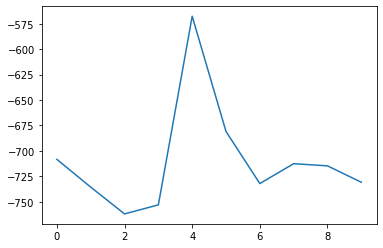

In [23]:
plt.plot(rme_dqn_rewards);

In [24]:
rme = RandomMazeEnvironment({})
obs = rme.reset() 
rme.render()

P.X..
....X
.....
...X.
..X.E


In [25]:
obs

array([1, 0, 1, 0])

In [26]:
action = rme_dqn_trainer.compute_single_action(input_dict={"obs": obs}, explore=False)
res = rme.step(action)
obs = res[0]
rme.render()

print("\naction:", action_names[action])
print("reward:", res[1])
print("done:", res[2])
print("obs:", obs)

P.X..
....X
.....
...X.
..X.E

action: up
reward: -8
done: False
obs: [1 0 1 0]


In [27]:
policy = rme_dqn_trainer.get_policy()
model = policy.model

In [28]:
obs

array([1, 0, 1, 0])

In [34]:
model_output = model({"obs": torch.from_numpy(obs)})[0]

In [35]:
q_values = model.get_q_value_distributions(model_output)

In [36]:
q_values

(tensor([[ 0.3954,  0.2392,  0.1865, -0.1616]], grad_fn=<AddmmBackward0>),
 tensor([[[1.],
          [1.],
          [1.],
          [1.]]]),
 tensor([[[1.],
          [1.],
          [1.],
          [1.]]]))

In [37]:
list(rme_dqn_trainer.get_policy().get_weights().values())[0].shape

(1, 64)

In [38]:
rme_dqn_trainer.evaluate()

{'evaluation': {'episode_reward_max': nan,
  'episode_reward_min': nan,
  'episode_reward_mean': nan,
  'episode_len_mean': nan,
  'episode_media': {},
  'episodes_this_iter': 0,
  'policy_reward_min': {},
  'policy_reward_max': {},
  'policy_reward_mean': {},
  'custom_metrics': {},
  'hist_stats': {'episode_reward': [], 'episode_lengths': []},
  'sampler_perf': {},
  'off_policy_estimator': {},
  'timesteps_this_iter': 40}}

Idea: give the agent an action that says "give up", take a reward hit, but move on.
So basically, see if they can figure out if it's unsolvable.